Exploring features for the multiple linear regression and random forests model for generating the recommendation/ratings system based on yelp reviews, user and business data. These models are built for specific cities spread across four different states. The four cities are Charlotte (NC), Las Vegas (NV), Phoenix (AZ), Pittsburgh (PA).

#Business data (interested features): spatial location (latitude/longitude), demographic (zip code/population density), review_count (weighted), cuisine type? (not sure), household income index? (not sure, if have time)

#User data (interested features):  average_stars, elite, fans, friends, gender, review_count(weighted)

#Review data (interested features): date, sentimental value(text input to NLTK, http://text-processing.com/demo/sentiment/), polarity, 

#Tip data (interested features):  date, sentimental value(text), polarity

Business based features

Feature#1 (Spatial location: latitude/longitude): Latitude/longitude values are given for each restaurant which would give us the spatial location within each city.

Feature#2 (zip code): In addition to the latitude/longitude values, zip codes are also provided as part of the address. We can see if there is any dependency of the target variable (rating) on the zip codes.

Feature#3 Population density (based on zip code): Population density is obtained from other data sources which shows the population within the zip code area.

Feature#4 review_count: Each restaurant has certain number of reviews within the yelp data. Number of reviews (review_count) shows how active and appealing a particular restaurant is to its customers.

User based features

Feature#5 gender: Gender is derived from a python library based on the name (https://pypi.python.org/pypi/SexMachine). We can see if there are any gender based differences in the reviews and the target variable (star rating) within each city.

Feature#6 user network index: this is derived from the user's active social participation in yelping using the values (fans and friends).

Feature#7: #years of user's elite status: Within the user's data, there is a field called 'elite' which shows the user's participation as an elite in each year.

Feature#8: average_stars (weighted): weight by quality of review.

Reviews based features: 

Feature#9: temporal index: Date is given for each review and we can derive a temporal index by looking into the #reviews within each time period. bin based on day/week, distribution analysis (for example skewness, lookinto ~10 restaurants). variability, 

Feature#10: sentimental value(text input to NLTK)

Feature#11: polarity (from NLTK)

Tip based features

Feature#12: temporal index: Date is given for each review and we can derive a temporal index by looking into the #reviews within each time period. 

Feature#13: sentimental value(text input to NLTK)

Feature#14: polarity (from NLTK)



In [169]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random
import scipy.stats as ss
from scipy.stats import norm
from textblob import TextBlob

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 10 columns):
business_id     2922 non-null object
categories      2922 non-null object
city            2922 non-null object
full_address    2922 non-null object
latitude        2922 non-null float64
longitude       2922 non-null float64
name            2922 non-null object
review_count    2922 non-null int64
stars           2922 non-null float64
state           2922 non-null object
dtypes: float64(3), int64(1), object(6)
memory usage: 251.1+ KB
None
2922


(array([  15.,   53.,  152.,  312.,    0.,  527.,  737.,  743.,  332.,   51.]),
 array([ 1. ,  1.4,  1.8,  2.2,  2.6,  3. ,  3.4,  3.8,  4.2,  4.6,  5. ]),
 <a list of 10 Patch objects>)

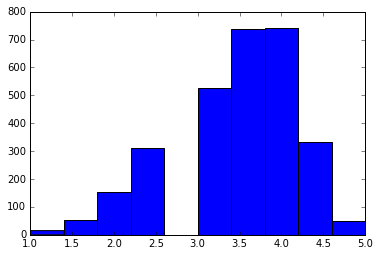

In [165]:
rest_df = pd.read_json('data_full/Phoenix_Restaurants.json')
#print(len(rest_df))
print(rest_df.info())
print(len(rest_df))
#print(rest_df.head(3))

plt.hist(rest_df['stars'])

In [17]:
user_df = pd.read_json('data_full/Phoenix_UserData.json')
print(len(user_df))
user_df.info()
user_df.head(10)

69473
<class 'pandas.core.frame.DataFrame'>
Float64Index: 69473 entries, 0.0 to 99988.0
Data columns (total 10 columns):
average_stars    69473 non-null float64
compliments      69473 non-null object
elite            69473 non-null object
fans             69473 non-null int64
friends          69473 non-null object
name             69473 non-null object
review_count     69473 non-null int64
user_id          69473 non-null object
votes            69473 non-null object
yelping_since    69473 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 5.8+ MB


,average_stars,compliments,elite,fans,friends,name,review_count,user_id,votes,yelping_since
0.0,3.33,{'plain': 6},[],0,"[C8ZTiwa7qWoPSMIivTeSfw, WRVrxPlDOCFsKmzhjdGqxg]",Gary,23,t95D1tnWvAOy2sxXnI3GUA,"{'cool': 13, 'useful': 36, 'funny': 25}",2008-11
10.0,4.43,{},[],0,[],Micheal,7,lkPszfTzL-Hb2zGJfMktWQ,"{'cool': 0, 'useful': 1, 'funny': 0}",2014-06
100.0,3.72,{'note': 1},[],0,"[AYGHNy8gPxl2Q-etTT3hZw, X_kPh3nt0AJPNPHye2rTlA]",Renee,41,r3_JcUFWGERe8ytAHQPDyQ,"{'cool': 27, 'useful': 58, 'funny': 28}",2008-08
1000.0,3.63,{},[],0,[],Chris,62,4mZHb-V_ik8YWrroeJHq0g,"{'cool': 7, 'useful': 17, 'funny': 2}",2009-05
10000.0,4.00,{},[],1,"[79MhROSJ1U8KBCupx7imRg, EOhPBTbSevH_dSRBmEi7z...",Travis,17,X57MxcGwDbaweQSOgXO8_w,"{'cool': 2, 'useful': 26, 'funny': 4}",2013-09
100000.0,4.05,"{'cool': 27, 'writer': 10, 'hot': 20, 'list': ...","[2007, 2008, 2009, 2010, 2011]",13,"[8J4IIYcqBlFch8T90N923A, VVFxkYuyuYEX22aTVjSCt...",Jennifer,386,wRD-UOmN5K0dlX5aMjm5gQ,"{'cool': 414, 'useful': 638, 'funny': 276}",2006-11
100001.0,2.82,"{'writer': 1, 'more': 1, 'note': 1, 'funny': 1...",[],1,"[BVvOPie8AA2xrHsjbyrd_g, sEWeeq41k4ohBz4jS_iGR...",Stephanie,35,hC3XkU_GzvypLHfkX6770g,"{'cool': 22, 'useful': 59, 'funny': 19}",2009-03
100002.0,3.91,"{'cute': 1, 'note': 1, 'writer': 1, 'hot': 1, ...",[],0,[sEWeeq41k4ohBz4jS_iGRw],Mikell,34,ZP-lKmBQAN4HIdLP4vDK6g,"{'cool': 27, 'useful': 38, 'funny': 11}",2007-04
100003.0,3.89,"{'cool': 3, 'hot': 1, 'note': 2, 'plain': 1}","[2010, 2011]",2,"[27MmRg8LfbZXNEHkEnKSdA, HOleI3jz1MLNUJ6cc1x0P...",Sara,45,IUWjTmXc3wLVaMHz33inaA,"{'cool': 27, 'useful': 89, 'funny': 19}",2009-03
100004.0,3.95,"{'writer': 15, 'note': 10, 'more': 4, 'cool': ...","[2009, 2010, 2011, 2012]",11,"[C8ZTiwa7qWoPSMIivTeSfw, fczQCSmaWF78toLEmb0Zs...",ben,163,d2RAl63RTdfZF7kcuKcj-g,"{'cool': 195, 'useful': 448, 'funny': 214}",2009-03


In [8]:
review_df = pd.read_json('data_full/Phoenix_ReviewData.json')
print(len(review_df))
review_df.info()
review_df.head(5)

188504
<class 'pandas.core.frame.DataFrame'>
Float64Index: 188504 entries, 0.0 to 99999.0
Data columns (total 7 columns):
business_id    188504 non-null object
date           188504 non-null datetime64[ns]
review_id      188504 non-null object
stars          188504 non-null int64
text           188504 non-null object
user_id        188504 non-null object
votes          188504 non-null object
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 11.5+ MB


,business_id,date,review_id,stars,text,user_id,votes
0.0,x5Mv61CnZLohZWxfCVCPTQ,2010-04-02,4ibY4fPQYM7FBSVPrvrYvg,4,Not the same Domino's pizza I ate too much of ...,t95D1tnWvAOy2sxXnI3GUA,"{'funny': 0, 'cool': 0, 'useful': 1}"
1.0,x5Mv61CnZLohZWxfCVCPTQ,2010-05-03,1JlopVxrAeDNQCRnSHLHrQ,4,Easy ordering-on-line. Made exactly as I asked...,t95D1tnWvAOy2sxXnI3GUA,"{'funny': 0, 'cool': 0, 'useful': 1}"
10.0,x5Mv61CnZLohZWxfCVCPTQ,2015-02-04,SHRKu4T-PI5WJuoGN7Mo4w,5,Love the online ordering ....... order was acc...,lkPszfTzL-Hb2zGJfMktWQ,"{'funny': 0, 'cool': 0, 'useful': 0}"
100.0,KPoTixdjoJxSqRSEApSAGg,2010-04-24,BWMfW_b6H22B3wsjHXNP_A,5,"Galee gai is the cure-all for allergies, the f...",r3_JcUFWGERe8ytAHQPDyQ,"{'funny': 0, 'cool': 1, 'useful': 0}"
1000.0,BESmH-lmMm34_EefL8X9fQ,2010-03-30,m9j1pHDGbImvkZjaYYF-ug,5,I was extremely happy with my meal here. The ...,4mZHb-V_ik8YWrroeJHq0g,"{'funny': 0, 'cool': 0, 'useful': 0}"


In [15]:
tip_df = pd.read_json('data/Phoenix_TipData.json')
print(len(tip_df))
tip_df.info()
tip_df.loc[tip_df['likes'].idxmax()]

54085
<class 'pandas.core.frame.DataFrame'>
Float64Index: 54085 entries, 0.0 to 9999.0
Data columns (total 5 columns):
business_id    54085 non-null object
date           54085 non-null datetime64[ns]
likes          54085 non-null int64
text           54085 non-null object
user_id        54085 non-null object
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 2.5+ MB


business_id    9-cRrGH5WmZKQ_O6LtfSbw
date              2014-09-07 00:00:00
likes                               3
text             Pumpkin beer is here
user_id        4DsUW5yuIkUcZ9Eu7p7EuA
Name: 34900.0, dtype: object

In [13]:
#extract feature#1 (latitude of restaurant)

def extract_feature1(city_rb_df):
    latitude = city_rb_df['latitude']
    return latitude


In [14]:
#extract feature#2 (longitude of restaurant)

def extract_feature2(city_rb_df):
    latitude = city_rb_df['longitude']
    return longitude

In [51]:
#extract feature#3 (zipcode of restaurant)

def extract_feature3(city_rb_df):
    zipcodes= []
    address = city_rb_df['full_address']
    for entry in address:
        entries = entry.split(" ")
        #print(entries[-1])
        zipcode = entries[-1]
        if(zipcode.isdigit()):
            zipcodes.append(int(zipcode))
        else:
            zipcodes.append(zipcodes[-1])
        
    return zipcodes

In [56]:
#extract feature#4 (population density based on zipcode)

def extract_feature4(zipcodes):
    pop_densities = []
    unique_zipcodes = list(set(zipcodes))
    pop_density_df = pd.read_excel('data_full/Zipcode-ZCTA-Population-Density-And-Area-Unsorted.xlsx', converters={'Zip/ZCTA': str})

    for each_zipcode in unique_zipcodes:
        idx = pop_density_df[pop_density_df['Zip/ZCTA'] == str(each_zipcode)].index.tolist()
        #print(each_zipcode)
        #print(idx)
        if idx:
            pop_densities.append(pop_density_df['Density Per Sq Mile'][idx[0]])
        else:
            pop_densities.append('NA')
    
    print(len(pop_densities))
    return(pop_densities)

In [69]:
#extract feature#5 (review_count)

def extract_feature5(city_rb_df):
    review_count = city_rb_df['review_count']
    return review_count
   

In [16]:
#extract feature#6 (gender from user's first name)

def extract_feature6(user_df):
    import sexmachine.detector as gender
    d = gender.Detector(case_sensitive=False)

    mapped_gender = []
    names = user_df['name']
    for name in names:
        mapped_name = d.get_gender(name, 'usa');
        if(mapped_name == 'mostly_male'):
            mapped_name = 'male'
        elif(mapped_name == 'mostly_female'):
            mapped_name = 'female'
        elif(mapped_name == 'andy'):
            irand = random.randint(0,1)
            if(irand):
                mapped_name = 'male'
            else:
                mapped_name = 'female'
        mapped_gender.append(mapped_name)
        
        return mapped_gender


In [30]:
#extract feature#7 (user network index derived from user's fan and friends)

def extract_feature7(user_df):
    num_friends = []
    sum_index = []
    fanlist = (user_df['fans'])
    friends = user_df['friends']
    for friendentry in friends:
        num_friends.append(len(friendentry))
    sum_index = fanlist + num_friends
    max_index = max(sum_index)
    print(max_index)
    network_index = sum_index/max_index
    return network_index

In [33]:
#extract feature#8 (#years as elite status)

def extract_feature8(user_df):
    num_elite = []
    elite = user_df['elite']
    for eliteentry in elite:
        num_elite.append(len(eliteentry))
    
    return num_elite

In [ ]:
#extract feature#9 (#average weighted rating)

def extract_feature9(user_df):
    avg_rating = review_df['average_stars']
    return avg_rating


In [167]:
#extract feature#10 (#skewness of review distribution)

def extract_feature10(review_df):
    skewfactors = []
    mulist = []
    stdlist = []
    df_grp_business = review_df.groupby(review_df.business_id).count()
    
    businesses = df_grp_business.index
    for businessid in businesses:
        df_point = review_df[review_df['business_id'] == businessid]
        date_series = df_point['date'].groupby([df_point.date.dt.year, df_point.date.dt.month]).count()
        mu, std = norm.fit(date_series)
        skewness = ss.skew(date_series)
        mulist.append(mu)
        stdlist.append(stdlist)
        skewfactors.append(skewness)
        #print(mu, std, skewness)
        
    skewfactors_reordered = []
    orig_businesses = rest_df['business_id']
    for businessid in orig_businesses:
        index=0
        match=False
        for index in range (0,len(businesses)):
            if(businesses[index] == businessid):
                skewfactors_reordered.append(skewfactors[index])
                index = len(businesses)
                match=True
        if(match == False):
            skewfactors_reordered.append(0)
    return skewfactors_reordered

In [168]:
skewfactors = extract_feature10(review_df)
print(len(skewfactors))

2922


In [171]:
#extract feature#11 (sentimental analysis for reviews)

def extract_feature11and12(review_df):
    polarityList = []
    subjectivityList = []
    reviews = review_df['text']
    for each_review in reviews:
        pol, subjectivity = TextBlob(each_review).sentiment
        polarityList.append(pol)
        subjectivityList.append(subjectivity)
    
    print(len(polarityList), len(subjectivityList))
    
    return polarityList, subjectivityList

In [172]:
polList, subjList  = extract_feature11and12(review_df)

#TextBlob("not a very great calculation").sentiment

188504 188504


In [60]:
rest_df = pd.read_json('data_full/Phoenix_Restaurants.json')
print(len(rest_df))
zipcodes = extract_feature3(rest_df)
pop_densities = extract_feature4(zipcodes)
review_count = extract_feature5(rest_df)
print(len(review_count))

2922
Phoenix, AZ 85001
58
2922


In [34]:
extract_feature8(user_df)

[0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 2,
 4,
 0,
 6,
 5,
 0,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 5,
 0,
 0,
 0,
 3,
 2,
 0,
 0,
 3,
 4,
 7,
 5,
 0,
 6,
 0,
 0,
 0,
 3,
 0,
 2,
 5,
 6,
 0,
 0,
 0,
 0,
 0,
 6,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 7,
 0,
 0,
 3,
 0,
 2,
 7,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 5,
 8,
 3,
 6,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 4,
 4,
 1,
 6,
 0,
 2,
 6,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 5,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 6,
 0,
 0,
 2,
 0,
 0,
 3,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 3,
 0,
 8,
 0,
 6,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 1,
 4,
 0,
 0,
 0,
 9,
 6,
 8,
 0,
 3,
 6,
 0,
 0,
 2,
 0,
 5,
 0,
 0,
 8,
 4,
 0,
 5,
 0,
 0,
 0,
 4,
 5,
 5,
 0,
 0,
 3,
 8,
 0,
 7,
 2,
 0,
 0,
 0,
 5,
 7,
 3,
 0,
 0,
 6,
 2,
 0,
 2,
 8,
 0,
 0,
 3,
 0,
 1,
 0,
 0,
 1,
 0,
 7,
 2,
 5,
 0,
 2,
 0,
 0,
 0,
